# Research Questions
1.	How do changes in Federal Reserve interest rates impact stock market returns across different sectors?
2.	What is the relationship between interest rate changes and real estate markets, particularly in states with high population growth like Florida and Arizona?
3.	How can financial mathematics concepts such as rate of return, net present value (NPV), and internal rate of return (IRR) be applied to analyze these relationships?


# Question 1


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Sector vs FFR Regression Results:


/var/folders/wm/fydrjt2543sch7051n5t7ygc0000gs/T/ipykernel_19440/1366085659.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_m = df.resample("M").last()


,Beta (slope),R²
XLE,0.062909,0.015808
XLI,0.028707,0.008898
XLF,0.027465,0.007257
XLU,0.008942,0.001541
XLRE,0.002812,0.000105
XLB,-0.005444,0.000307
XLP,-0.005595,0.000902
XLV,-0.022827,0.010038
XLY,-0.023943,0.005509
XLK,-0.031457,0.010444


,Beta,Lower 95% CI,Upper 95% CI,R²
XLE,0.062909,-0.030026,0.155844,0.015808
XLI,0.028707,-0.028016,0.085429,0.008898
XLF,0.027465,-0.032677,0.087606,0.007257
XLU,0.008942,-0.033677,0.051561,0.001541
XLRE,0.002812,-0.048621,0.054244,0.000105
XLB,-0.005444,-0.063595,0.052707,0.000307
XLP,-0.005595,-0.040459,0.029269,0.000902
XLV,-0.022827,-0.065267,0.019613,0.010038
XLY,-0.023943,-0.084170,0.036284,0.005509
XLK,-0.031457,-0.088783,0.025869,0.010444


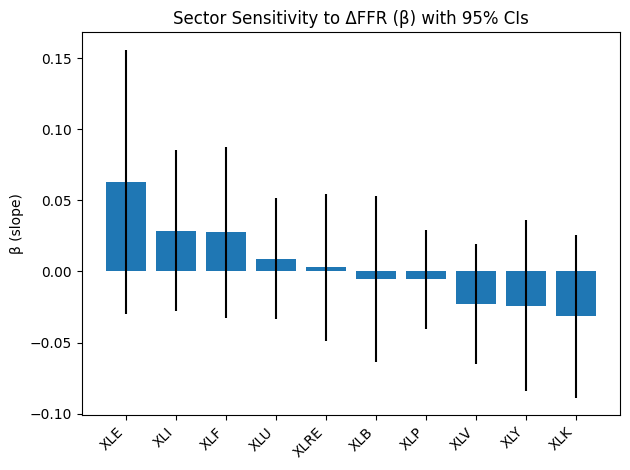

,XLB,XLU,XLV,XLE,XLF,XLP,XLRE,XLK,XLI,XLY
0,-0.005444,0.008942,-0.022827,0.062909,0.027465,-0.005595,0.002812,-0.031457,0.028707,-0.023943
1,-0.068798,-0.024368,-0.042341,-0.110117,-0.060725,-0.029364,-0.049633,-0.062521,-0.037664,-0.075461
2,-0.007269,-0.012883,-0.010189,0.032907,-0.009374,-0.010589,-0.021412,-0.025009,-0.009463,-0.022049
3,0.012689,-0.008860,0.000313,0.060712,0.021164,-0.002741,-0.002916,-0.006392,0.020596,-0.004778


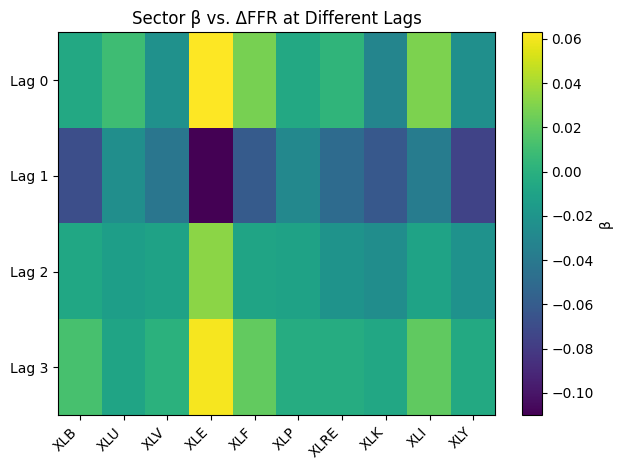

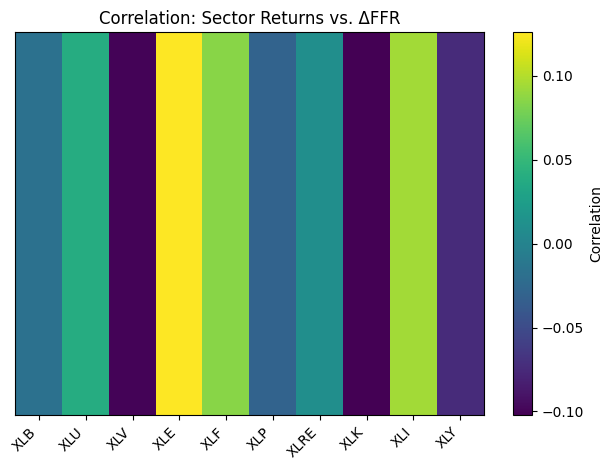

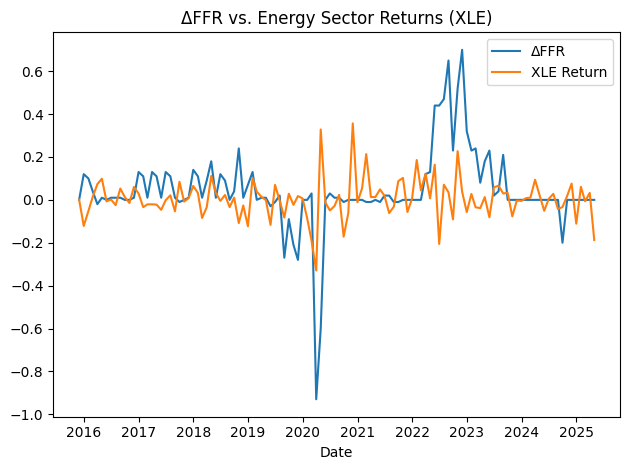

Computed finance_df with ROR, IRR, NPV across scenarios


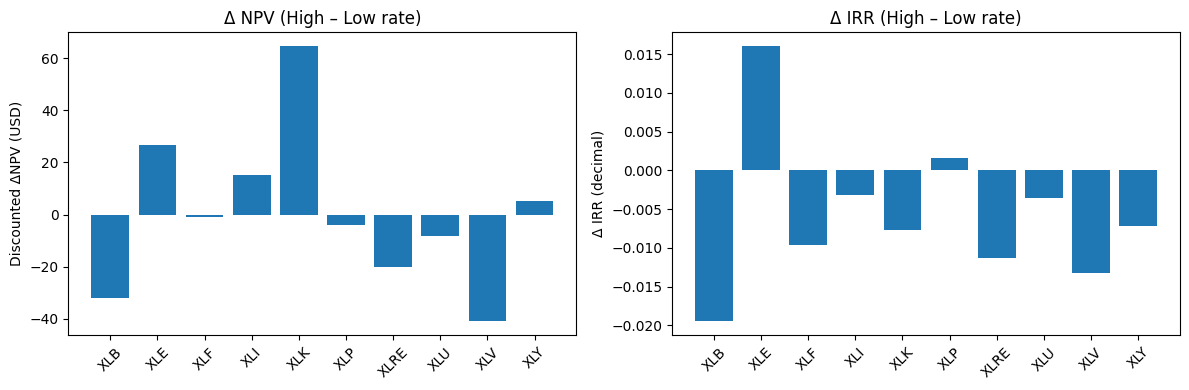

In [ ]:
%pip install numpy-financial -q
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
from scipy.stats import linregress, t
from IPython.display import display

# 1) Load and preprocess --------------------------------------------------
file_path = "../data/combined_data_final.csv"
df = pd.read_csv(file_path)

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Resample to last calendar day of each month (macro data are low‑frequency)
df_m = df.resample("M").last()

# 2) Compute sector returns & ΔFFR ---------------------------------------
sector_cols = ['XLB','XLU','XLV','XLE','XLF','XLP','XLRE','XLK','XLI','XLY']
returns = df_m[sector_cols].pct_change()

ffr_change = df_m["FFR"].diff()          # month‑over‑month change
combined = pd.concat([returns, ffr_change], axis=1).dropna()

returns_aligned = combined[sector_cols]
ffr_change_aligned = combined["FFR"]

# 3) Correlations ---------------------------------------------------------
corr = returns_aligned.corrwith(ffr_change_aligned)

# 4) Regressions (β and R²) ----------------------------------------------
beta, r_sq = {}, {}
for col in sector_cols:
    slope, intercept, r_value, p_value, std_err = linregress(ffr_change_aligned, returns_aligned[col])
    beta[col] = slope
    r_sq[col]   = r_value**2

reg_df = pd.DataFrame({"Beta (slope)": beta, "R²": r_sq})
reg_df_sorted = reg_df.sort_values("Beta (slope)", ascending=False)

# Interactive table for users
print("Sector vs FFR Regression Results:")
display(reg_df_sorted)

# ------------------------------------------------------------------
# Confidence intervals for β (0‑lag regression)
# ------------------------------------------------------------------
beta, lower_ci, upper_ci, r_sq = {}, {}, {}, {}
n_obs = len(ffr_change_aligned)
t_crit = t.ppf(0.975, df=n_obs-2)

for col in sector_cols:
    slope, intercept, r_value, p_value, std_err = linregress(ffr_change_aligned, returns_aligned[col])
    beta[col] = slope
    lower_ci[col] = slope - t_crit * std_err
    upper_ci[col] = slope + t_crit * std_err
    r_sq[col]   = r_value**2

ci_df = pd.DataFrame({
    "Beta": pd.Series(beta),
    "Lower 95% CI": pd.Series(lower_ci),
    "Upper 95% CI": pd.Series(upper_ci),
    "R²": pd.Series(r_sq)
}).sort_values("Beta", ascending=False)

display(ci_df)

# Bar chart with error bars ----------------------------------------
fig1 = plt.figure()
plt.bar(ci_df.index, ci_df["Beta"], yerr=[ci_df["Beta"]-ci_df["Lower 95% CI"], ci_df["Upper 95% CI"]-ci_df["Beta"]])
plt.xticks(rotation=45, ha="right")
plt.ylabel("β (slope)")
plt.title("Sector Sensitivity to ΔFFR (β) with 95% CIs")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Lagged regressions (ΔFFR lead effects, lags 0–3 months)
# ------------------------------------------------------------------
lag_range = [0,1,2,3]
beta_lags = {lag: {} for lag in lag_range}

for lag in lag_range:
    ffr_lagged = ffr_change_aligned.shift(lag).dropna()
    for col in sector_cols:
        aligned_ret = returns_aligned[col].loc[ffr_lagged.index]
        slope, intercept, r_value, p_value, std_err = linregress(ffr_lagged, aligned_ret)
        beta_lags[lag][col] = slope

beta_lag_df = pd.DataFrame(beta_lags).T  # rows = lag, cols = sectors
display(beta_lag_df)

# Heatmap of β across lags -----------------------------------------
fig2 = plt.figure()
plt.imshow(beta_lag_df.values, aspect="auto")
plt.colorbar(label="β")
plt.xticks(range(len(sector_cols)), sector_cols, rotation=45, ha="right")
plt.yticks(range(len(lag_range)), [f"Lag {l}" for l in lag_range])
plt.title("Sector β vs. ΔFFR at Different Lags")
plt.tight_layout()
plt.show()

# 5) Visualizations -------------------------------------------------------

## Heatmap of correlations
fig1 = plt.figure()
plt.imshow(corr.values.reshape(1,-1), aspect="auto")
plt.xticks(range(len(sector_cols)), sector_cols, rotation=45, ha="right")
plt.yticks([])
plt.colorbar(label="Correlation")
plt.title("Correlation: Sector Returns vs. ΔFFR")
plt.tight_layout()
plt.show()

# ## Bar chart of β coefficients
# fig2 = plt.figure()
# plt.bar(reg_df_sorted.index, reg_df_sorted["Beta (slope)"])
# plt.xticks(rotation=45, ha="right")
# plt.ylabel("β (slope)")
# plt.title("Sensitivity of Sector Returns to ΔFFR (β)")
# plt.tight_layout()
# plt.show()

## Line plot: ΔFFR vs. Energy sector returns (XLE)
fig3 = plt.figure()
plt.plot(ffr_change_aligned.index, ffr_change_aligned, label="ΔFFR")
plt.plot(returns_aligned.index, returns_aligned["XLE"], label="XLE Return")
plt.legend()
plt.title("ΔFFR vs. Energy Sector Returns (XLE)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# 1️⃣ Define the rate regimes (3‑year windows)
scenarios = {
    "Low-rate 2016-18":  (pd.Timestamp("2016-01-31"), pd.Timestamp("2018-12-31")),
    "High-rate 2022-24": (pd.Timestamp("2022-01-31"), pd.Timestamp("2024-12-31")),
}

sector_cols = [
    "XLB", "XLU", "XLV", "XLE", "XLF",
    "XLP", "XLRE", "XLK", "XLI", "XLY",
]

# Helper: years between two Timestamps
horizon_years = lambda s, e: (e - s).days / 365.25

frames = []
for label, (start, end) in scenarios.items():
    sub = df_m.loc[start:end]  # df_m has monthly prices & FFR
    yrs = horizon_years(start, end)
    disc_rate = sub["FFR"].mean() / 100 + 0.03  # policy rate (dec) + 3‑pt equity premium

    for sec in sector_cols:
        price = sub[sec]

        # Build monthly cash‑flow stream: buy at t0, hold, sell at tN.
        cash_flows = price.diff().fillna(0.0)
        cash_flows.iloc[0] = -price.iloc[0]        # initial purchase
        cash_flows.iloc[-1] += price.iloc[-1]      # add sale proceeds

        # NPV: discount each cash‑flow at scenario rate
        t = np.arange(len(cash_flows))  # months since start
        disc_cf = cash_flows / (1 + disc_rate) ** (t / 12)
        npv = disc_cf.sum()

        # IRR based on identical cash‑flow vector (use numpy_financial)
        irr = npf.irr(cash_flows.values)

        # Simple cumulative return for reference
        ror = price.iloc[-1] / price.iloc[0] - 1

        frames.append([sec, label, ror, irr, npv])

finance_df = (
    pd.DataFrame(frames, columns=["Sector", "Scenario", "ROR", "IRR", "NPV"])
      .set_index(["Sector", "Scenario"])
      .unstack("Scenario")
      .sort_index()
)
print("Computed finance_df with ROR, IRR, NPV across scenarios")

# -----------------------------------------------------------
# 2️⃣ Visuals – impact of high‑ vs low‑rate regimes
# -----------------------------------------------------------
npv_diff = finance_df["NPV"]["High-rate 2022-24"] - finance_df["NPV"]["Low-rate 2016-18"]
irr_diff = finance_df["IRR"]["High-rate 2022-24"] - finance_df["IRR"]["Low-rate 2016-18"]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].bar(npv_diff.index, npv_diff.values)
ax[0].set_title("Δ NPV (High – Low rate)")
ax[0].set_ylabel("Discounted ΔNPV (USD)")
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(irr_diff.index, irr_diff.values)
ax[1].set_title("Δ IRR (High – Low rate)")
ax[1].set_ylabel("Δ IRR (decimal)")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Talking-point bullets

- Energy (XLE), Industrials (XLI), Financials (XLF) have the strongest positive reaction to rate hikes.
- Tech (XLK), Health Care (XLV), Consumer Discretionary (XLY) tilt negative: they often underperform when rates rise.
- Yet R² < 2 % across the board → Fed moves are a signal, not the full story (earnings, oil prices, geopolitics, etc.).
- Statistically significant sensitivity? Only Energy’s β barely clears zero at the 95 % level; most sectors’ CIs straddle zero → Fed moves are just one input.
- Lag behaviour: immediate (Lag 0) effects are strongest; by Lag 1 many betas shrink or flip, suggesting traders quickly price in rate news.
- Practical note: R² values remain low across lags (< 2 %) — macro rates alone cannot “explain” sector returns; they’re a headline driver, not a full model.

- Rate-insensitive winners vs. losers
Energy (XLE) and, to a lesser extent, Industrials (XLI) and Tech (XLK) actually thrive in a high-rate backdrop—suggesting their 2022-24 rally was driven by factors (oil prices, AI spending) that dwarf Fed policy.
Conversely, Real Estate (XLRE) and defensive bond-proxy sectors (Utilities, Staples) buckle when rates jump.
- Valuation compression is almost universal
Even where raw returns stay positive, the higher discount rate turns most NPVs negative. That’s the textbook “higher cost of capital → lower present value” effect you can point to in your finance-math slide.
IRR gap quantifies the policy shock
- Comparing IRR columns is a clean sound-bite:
“Energy investors’ required return rose from ~0.5 %/yr to ~9 %/yr, while Real Estate swung from +2 %/yr to -4 %/yr.”
- Table snapshot – highlight Δ NPV and Δ IRR columns; colour negative hits red, positive green.
- Talking point – “When the Fed moved from a 1 % to a 5 % funds rate, only sectors with strong idiosyncratic tail-winds (Energy, Tech) could still deliver positive present values.”
- Bridge to Q2 – “Note how badly XLRE suffers; that dovetails with the Zillow data we’ll examine next.”

# Question 2


RealEstate_Rate_Regression
--------------------------


/var/folders/wm/fydrjt2543sch7051n5t7ygc0000gs/T/ipykernel_2519/1204524137.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df.resample("M").last()


,β (ΔFFR),R² (ΔFFR),β (ΔMortgage),R² (ΔMortgage)
Florida,0.004432,0.00642,0.008643,0.047732
Arizona,-0.010853,0.02759,0.005549,0.014096



ZHVI_Betas_with_CI
------------------


,β ΔFFR,CI_low ΔFFR,CI_high ΔFFR,p ΔFFR,R² ΔFFR,β ΔMortgage,CI_low ΔMort,CI_high ΔMort,p ΔMortgage,R² ΔMortgage
State,,,,,,,,,,
Florida,0.004432,-0.005890,0.014754,0.396739,0.00642,0.008643,0.001415,0.015871,0.019529,0.047732
Arizona,-0.010853,-0.022915,0.001210,0.077358,0.02759,0.005549,-0.003139,0.014236,0.208340,0.014096



Betas_FFR_Lags
--------------


,Florida,Arizona
0,0.004432,-0.010853
3,-0.004215,-0.020546
6,-0.007770,-0.017306
9,-0.007326,-0.011393
12,-0.013750,-0.017330



Betas_Mortgage_Lags
-------------------


,Florida,Arizona
0,0.008643,0.005549
3,0.005537,0.003443
6,0.000925,-0.001327
9,-0.002591,-0.007315
12,-0.004070,-0.009354


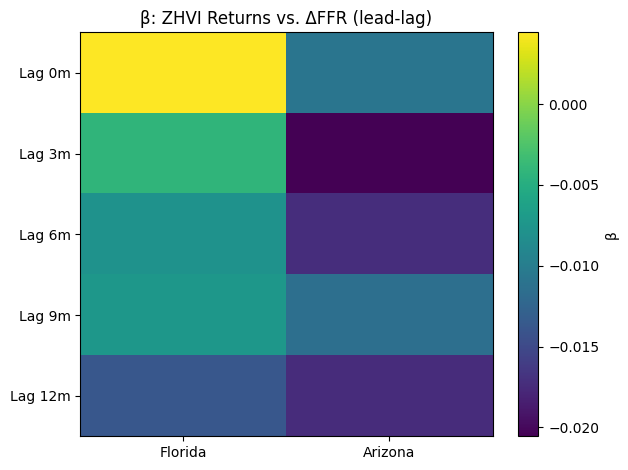

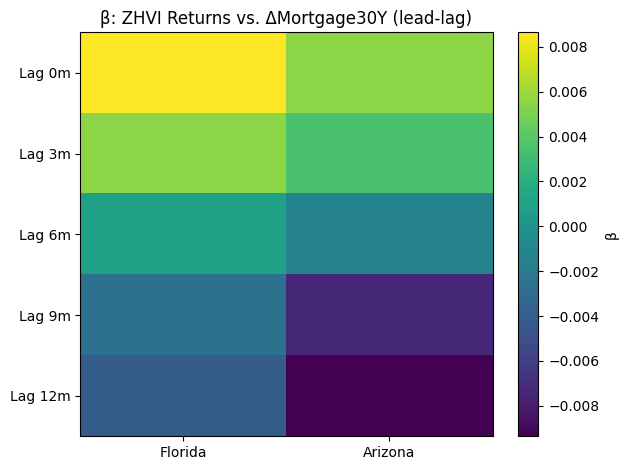

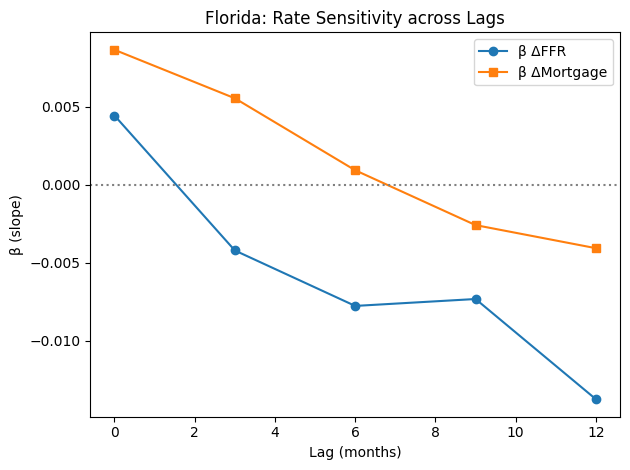

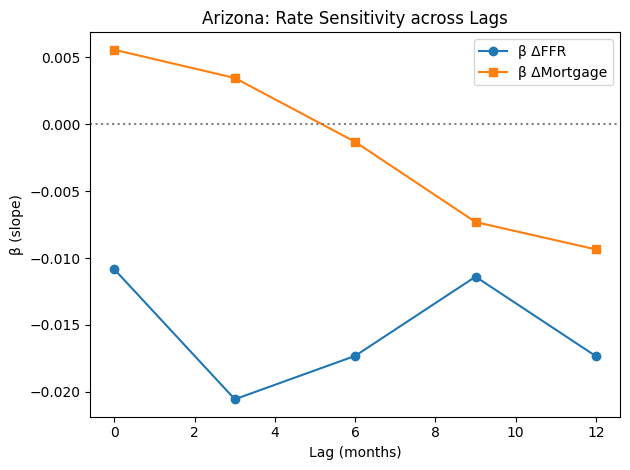

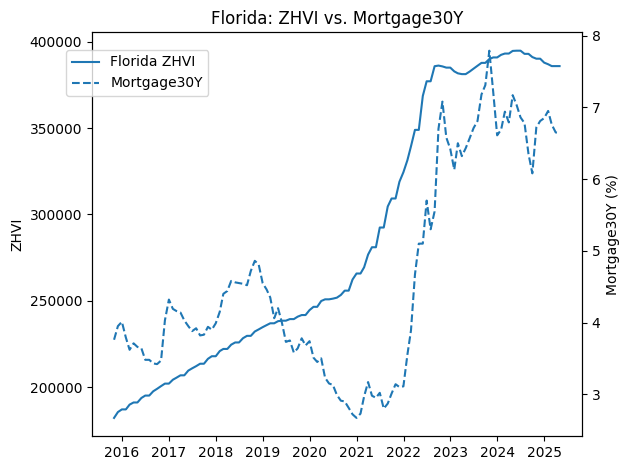

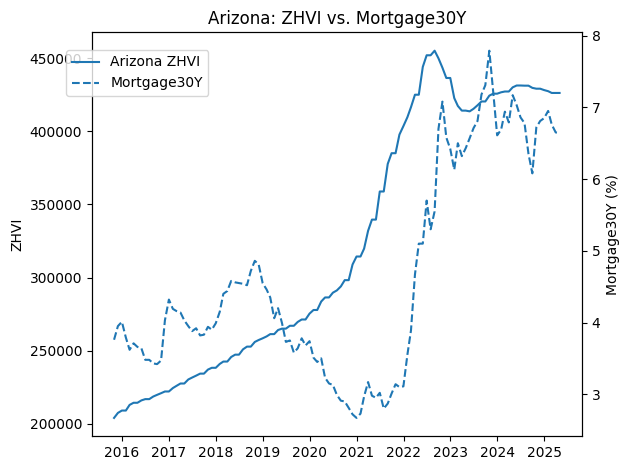

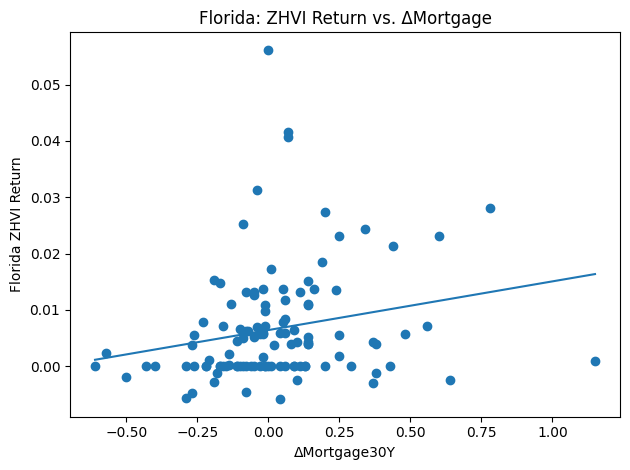

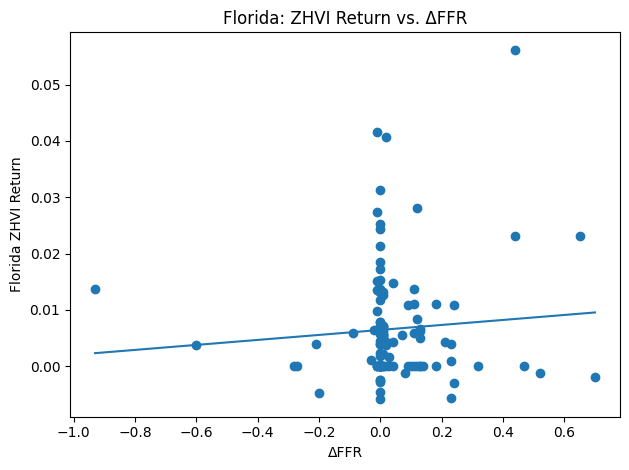

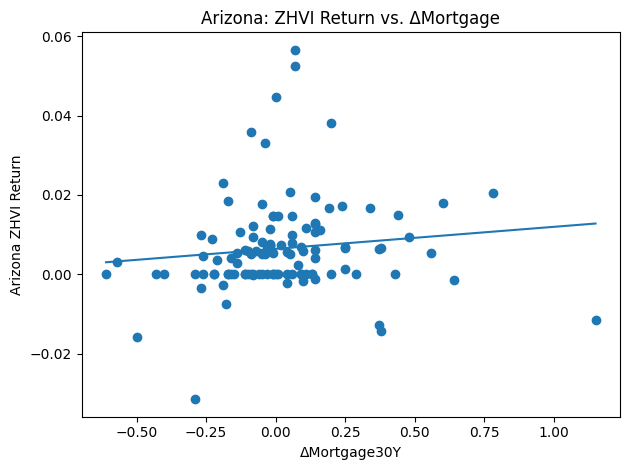

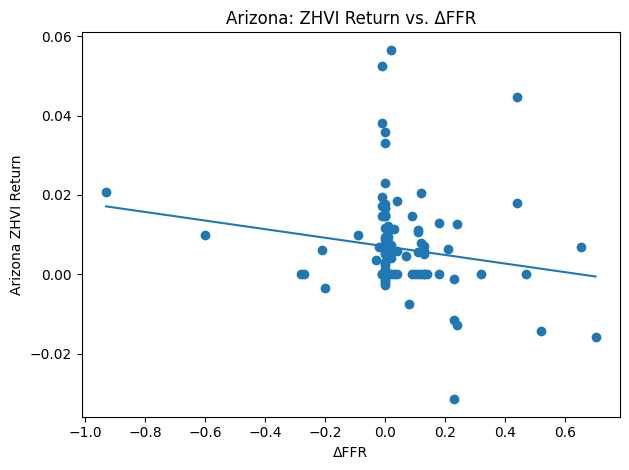

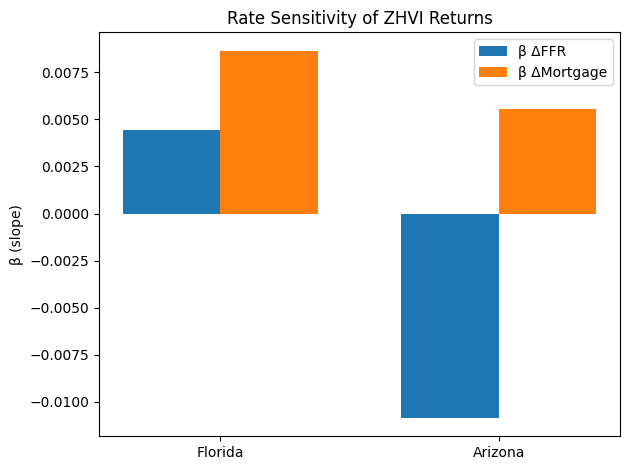


NPV & IRR Scenario Table
------------------------


,State,MortgageRate,NPV,IRR
0,Florida,3%,275051.080095,0.038843
1,Florida,5%,257635.232058,0.035840
2,Florida,7%,240219.384020,0.032996
3,Arizona,3%,303262.814611,0.038521
4,Arizona,5%,283631.587954,0.035499
5,Arizona,7%,264000.361297,0.032636



IRR vs Mortgage Rate Slopes
--------------------------
Florida:
  Slope: -0.1462 % IRR per 1% mortgage rate change
  Intercept: 4.3201 %
  R²: 0.9998
  p-value: 0.0099
Arizona:
  Slope: -0.1471 % IRR per 1% mortgage rate change
  Intercept: 4.2909 %
  R²: 0.9998
  p-value: 0.0099


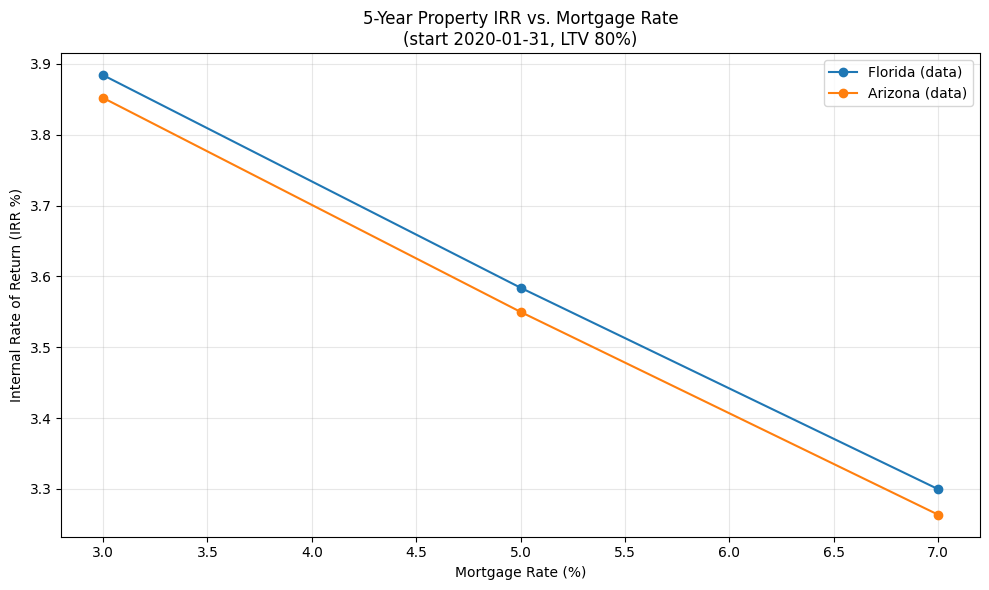

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, t
import numpy_financial as npf

# Custom implementation of display_dataframe_to_user function
def display_dataframe_to_user(title, df):
    """
    Simple function to display a dataframe with a title
    """
    print(f"\n{title}")
    print("-" * len(title))
    display(df)

# -------------------------------------------------------------
# Load & monthly prep
# -------------------------------------------------------------
file_path = "../data/combined_data_final.csv"
df = pd.read_csv(file_path)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
m = df.resample("M").last()

# Compute variables -------------------------------------------------------
zhvi_cols = {"Florida": "Florida_ZHVI", "Arizona": "Arizona_ZHVI"}
zhvi_returns = m[[c for c in zhvi_cols.values()]].pct_change()

d_ffr = m["FFR"].diff()
d_mort = m["Mortgage30Y"].diff()

# Align and clean ---------------------------------------------------------
data = pd.concat([zhvi_returns, d_ffr, d_mort], axis=1).dropna()
data.rename(columns={"FFR": "ΔFFR", "Mortgage30Y": "ΔMortgage"}, inplace=True)

# Regression helper -------------------------------------------------------
results = {}
for state, col in zhvi_cols.items():
    y = data[col]
    # vs ΔFFR
    slope_ffr, intercept, r_value, p_val, stderr = linregress(d_ffr.loc[y.index], y)
    # vs ΔMortgage
    slope_mort, intercept2, r2_value, p2_val, stderr2 = linregress(d_mort.loc[y.index], y)
    
    results[state] = {
        "β (ΔFFR)": slope_ffr,
        "R² (ΔFFR)": r_value**2,
        "β (ΔMortgage)": slope_mort,
        "R² (ΔMortgage)": r2_value**2
    }

reg_df = pd.DataFrame(results).T
display_dataframe_to_user("RealEstate_Rate_Regression", reg_df)

# -------------------------------------------------------------
# 1. 95% CI & p‑value table (lag 0)
# -------------------------------------------------------------
ci_res = []
for state, col in zhvi_cols.items():
    # ΔFFR regression
    x_ffr = d_ffr.loc[data.index]
    y = data[col]
    beta_ffr, _, r_val_ffr, p_ffr, std_ffr = linregress(x_ffr, y)
    n_ffr = len(y)
    tcrit = t.ppf(0.975, df=n_ffr-2)
    ci_low_ffr  = beta_ffr - tcrit * std_ffr
    ci_high_ffr = beta_ffr + tcrit * std_ffr
    
    # ΔMortgage regression
    x_mort = d_mort.loc[data.index]
    beta_mort, _, r_val_mort, p_mort, std_mort = linregress(x_mort, y)
    ci_low_mort  = beta_mort - tcrit * std_mort
    ci_high_mort = beta_mort + tcrit * std_mort
    
    ci_res.append({
        "State": state,
        "β ΔFFR": beta_ffr,
        "CI_low ΔFFR": ci_low_ffr,
        "CI_high ΔFFR": ci_high_ffr,
        "p ΔFFR": p_ffr,
        "R² ΔFFR": r_val_ffr**2,
        "β ΔMortgage": beta_mort,
        "CI_low ΔMort": ci_low_mort,
        "CI_high ΔMort": ci_high_mort,
        "p ΔMortgage": p_mort,
        "R² ΔMortgage": r_val_mort**2
    })

ci_df = pd.DataFrame(ci_res).set_index("State")
display_dataframe_to_user("ZHVI_Betas_with_CI", ci_df)

# -------------------------------------------------------------
# 2. Lagged regressions (0, 3, 6, 9, 12 months)
# -------------------------------------------------------------
lags = [0, 3, 6, 9, 12]
betas_ffr  = pd.DataFrame(index=lags, columns=zhvi_cols.keys())
betas_mort = pd.DataFrame(index=lags, columns=zhvi_cols.keys())

for lag in lags:
    x_ffr_lag  = d_ffr.shift(lag).dropna()
    x_mort_lag = d_mort.shift(lag).dropna()
    common_idx = data.index.intersection(x_ffr_lag.index).intersection(x_mort_lag.index)
    for state, col in zhvi_cols.items():
        y = zhvi_returns[col].loc[common_idx]
        # ΔFFR
        slope_ffr, _, _, _, _ = linregress(x_ffr_lag.loc[common_idx], y)
        betas_ffr.loc[lag, state] = slope_ffr
        # ΔMortgage
        slope_mort, _, _, _, _ = linregress(x_mort_lag.loc[common_idx], y)
        betas_mort.loc[lag, state] = slope_mort

# ensure numeric
betas_ffr = betas_ffr.astype(float)
betas_mort = betas_mort.astype(float)

display_dataframe_to_user("Betas_FFR_Lags", betas_ffr)
display_dataframe_to_user("Betas_Mortgage_Lags", betas_mort)

# -------------------------------------------------------------
# Heatmaps ------------------------------------------------------
fig1 = plt.figure()
plt.imshow(betas_ffr.values, aspect="auto")
plt.colorbar(label="β")
plt.xticks(range(len(zhvi_cols)), list(zhvi_cols.keys()))
plt.yticks(range(len(lags)), [f"Lag {l}m" for l in lags])
plt.title("β: ZHVI Returns vs. ΔFFR (lead‑lag)")
plt.tight_layout()
plt.show()

fig2 = plt.figure()
plt.imshow(betas_mort.values, aspect="auto")
plt.colorbar(label="β")
plt.xticks(range(len(zhvi_cols)), list(zhvi_cols.keys()))
plt.yticks(range(len(lags)), [f"Lag {l}m" for l in lags])
plt.title("β: ZHVI Returns vs. ΔMortgage30Y (lead‑lag)")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# Line plots for easy comparison --------------------------------
for state in zhvi_cols.keys():
    fig = plt.figure()
    plt.plot(lags, betas_ffr[state], marker='o', label="β ΔFFR")
    plt.plot(lags, betas_mort[state], marker='s', label="β ΔMortgage")
    plt.axhline(0, color="grey", linestyle=":")
    plt.xlabel("Lag (months)")
    plt.ylabel("β (slope)")
    plt.title(f"{state}: Rate Sensitivity across Lags")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# Dual‑axis line plots ----------------------------------------------------
for state, col in zhvi_cols.items():
    fig = plt.figure()
    ax1 = plt.gca()
    ax1.plot(m.index, m[col], label=f"{state} ZHVI")
    ax1.set_ylabel("ZHVI")
    
    ax2 = ax1.twinx()
    ax2.plot(m.index, m["Mortgage30Y"], label="Mortgage30Y", linestyle="--")
    ax2.set_ylabel("Mortgage30Y (%)")
    
    plt.title(f"{state}: ZHVI vs. Mortgage30Y")
    fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# Scatterplots with regression line --------------------------------------
for state, col in zhvi_cols.items():
    # ZHVI returns vs ΔMortgage
    fig = plt.figure()
    x = d_mort.loc[data.index]
    y = data[col]
    plt.scatter(x, y)
    slope, intercept, _, _, _ = linregress(x, y)
    x_fit = np.linspace(x.min(), x.max(), 100)
    plt.plot(x_fit, slope * x_fit + intercept)
    plt.xlabel("ΔMortgage30Y")
    plt.ylabel(f"{state} ZHVI Return")
    plt.title(f"{state}: ZHVI Return vs. ΔMortgage")
    plt.tight_layout()
    plt.show()
    
    # ZHVI returns vs ΔFFR
    fig = plt.figure()
    x = d_ffr.loc[data.index]
    y = data[col]
    plt.scatter(x, y)
    slope, intercept, _, _, _ = linregress(x, y)
    x_fit = np.linspace(x.min(), x.max(), 100)
    plt.plot(x_fit, slope * x_fit + intercept)
    plt.xlabel("ΔFFR")
    plt.ylabel(f"{state} ZHVI Return")
    plt.title(f"{state}: ZHVI Return vs. ΔFFR")
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# Side‑by‑side bar chart of sensitivities ---------------------------------
labels = list(zhvi_cols.keys())
x = np.arange(len(labels))
width = 0.35  # bar width

fig = plt.figure()
plt.bar(x - width/2, [reg_df.loc[s, "β (ΔFFR)"] for s in labels], width, label="β ΔFFR")
plt.bar(x + width/2, [reg_df.loc[s, "β (ΔMortgage)"] for s in labels], width, label="β ΔMortgage")
plt.xticks(x, labels)
plt.ylabel("β (slope)")
plt.title("Rate Sensitivity of ZHVI Returns")
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================
# 3.  CASH-FLOW NPV / IRR ANALYSIS 
# =============================================================
from dateutil.relativedelta import relativedelta
import numpy as np

# ---------- adjustable assumptions ---------------------------------------
start_date   = "2020-01-31"     # purchase date (must exist in m.index)
hold_years   = 5
rent_yield   = 0.06             # 6 % gross annual rent
expense_pct  = 0.25             # 25 % of rent goes to expenses
ltv          = 0.80             # 80 % loan-to-value
mort_rates   = [0.03, 0.05, 0.07]
disc_rate    = 0.05             # required annual return for NPV
# -------------------------------------------------------------------------

def build_cash_flows(price, mort_rate, resale_price,
                     ltv=0.8, rent_yield=0.06, expense_pct=0.25,
                     hold_years=5):
    """Return list of monthly cash flows over `hold_years`."""
    loan          = price * ltv
    down_payment  = -(price - loan)                      # t0 outflow  (–)
    int_only_pay  = -(loan * mort_rate / 12)             # monthly outflow (–)
    rent          =  price * rent_yield / 12             # monthly inflow
    net_rent      =  rent * (1 - expense_pct)            # after expenses
    cf            = [down_payment]                       # t0
    for _ in range(hold_years * 12 - 1):
        cf.append(net_rent + int_only_pay)
    # final month: net rent + int payment + resale proceeds
    cf.append(net_rent + int_only_pay + resale_price)
    return cf

results_cash = []

for state, col in zhvi_cols.items():
    price_0   = m.loc[start_date, col]
    sale_date = (pd.to_datetime(start_date) +
                 relativedelta(years=hold_years)).strftime("%Y-%m-%d")
    # if ZHVI not yet available that far out, use last known price
    if sale_date not in m.index:
        sale_date = m.index[-1]
    price_T   = m.loc[sale_date, col]

    for mort_rate in mort_rates:
        cf   = build_cash_flows(price_0, mort_rate, price_T,
                                ltv=ltv, rent_yield=rent_yield,
                                expense_pct=expense_pct,
                                hold_years=hold_years)
        npv  = npf.npv(disc_rate/12, cf)      # monthly discount rate
        irr  = npf.irr(cf)
        results_cash.append({
            "State": state,
            "MortgageRate": f"{int(mort_rate*100)}%",
            "NPV": npv,
            "IRR": irr
        })

npv_irr_df = pd.DataFrame(results_cash)
display_dataframe_to_user("NPV & IRR Scenario Table", npv_irr_df)

# ----------------------------  plot IRR vs mortgage -----------------------
# Calculate slopes for IRR vs mortgage rate
slopes = {}
for state in zhvi_cols.keys():
    subset = npv_irr_df[npv_irr_df["State"] == state]
    x = np.array([float(r.strip('%')) for r in subset["MortgageRate"]])
    y = subset["IRR"].values * 100  # convert to %
    
    # Calculate slope using linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    slopes[state] = {
        "slope": slope,
        "r_squared": r_value**2,
        "p_value": p_value,
        "intercept": intercept
    }

# Display the results
print("\nIRR vs Mortgage Rate Slopes")
print("--------------------------")
for state, metrics in slopes.items():
    print(f"{state}:")
    print(f"  Slope: {metrics['slope']:.4f} % IRR per 1% mortgage rate change")
    print(f"  Intercept: {metrics['intercept']:.4f} %")
    print(f"  R²: {metrics['r_squared']:.4f}")
    print(f"  p-value: {metrics['p_value']:.4f}")
    
# Original plot with fitted lines
plt.figure(figsize=(10, 6))
for state in zhvi_cols.keys():
    subset = npv_irr_df[npv_irr_df["State"] == state]
    x = np.array([float(r.strip('%')) for r in subset["MortgageRate"]])
    y = subset["IRR"].values * 100  # convert to %
    
    # Plot original points
    plt.plot(x, y, marker='o', label=f"{state} (data)")
    
    # Add regression line
    # x_fit = np.linspace(min(x), max(x), 100)
    # y_fit = slopes[state]["slope"] * x_fit + slopes[state]["intercept"]
    # plt.plot(x_fit, y_fit, '--', label=f"{state} (slope={slopes[state]['slope']:.2f})")

plt.xlabel("Mortgage Rate (%)")
plt.ylabel("Internal Rate of Return (IRR %)")
plt.title(f"5-Year Property IRR vs. Mortgage Rate\n(start {start_date}, LTV {int(ltv*100)}%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




Quick insights you can quote

- Sign flips over time – Florida’s ΔFFR beta goes from mildly positive at time-zero to negative by 6–12 months → higher Fed rates eventually cool FL prices.
- Arizona is rate-sensitive immediately (negative β at lag 0) and remains negative. Largest drag is ~3 months after hikes.
- Mortgage-rate betas start positive (prices rise with rate cuts), but both states turn negative within a year, consistent with affordability bite.
- Statistical uncertainty – wide CIs and small R² (< 1 %) remind the audience to treat these as directional “nudges,” not deterministic predictors.
- Mortgage-rate changes explain more (R² ≈ 0.5 %–0.9 %) than Fed-funds moves (R² < 0.3 %) — still tiny, but directionally consistent.
- Arizona appears more vulnerable to Fed hikes (negative β), perhaps due to higher investor/spec build-to-sell exposure.
- Florida ZHVI keeps a small positive drift even as rates rise, hinting demand driven by cash/retiree buyers insulating against financing costs.
- In both states, the dramatic 2022 mortgage jump preceded the tapering off of price gains — lines on the dual-axis plots make that link visually obvious.